![title](http://cs231n.github.io/assets/nn2/dropout.jpeg)

So after learning how to create and train a neural network on the last notebook, we successfully classified images between digits that are 0 or 1. In this notebook we'll go further beyond that, but we'll focus on two things: building a more general neural network class and applying some extra generalization and optimization functions for the network . We'll also use the full dataset for classifying handwritten digits, so the complexity is now greater! Let's first start with all the extra tidbits. 


## Dropout

Now before you go dropping this notebook, this is not about dropping the course. Dropout in neural networks is a process applied after the activation function where a proportion of results of the activation function are multiplied element-wise by a vector of the same size. This vector is the same size as the output of the activation function, and is filled with 1s and 0s. So after this multiplication, some of the results of the activation function are turned to 0 and others stay the same, essentially "dropping" some of the results. For example, if the dropout ratio was 0.5 then we would get:

- $y = f(x) \cdot m$ 

where $y$ is the output of the neuron, $f(x)$ is the activation function and m is the dropout vector, which would be 50% (0.5 dropout ratio) filled with 0s and the rest filled with 1s. A fully connected (Linear) layer occupies most of the parameters and neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to over-fitting of training data. With dropout, this dependency is reduced by a large amount, since each training epoch generates a "new" neural network. During testing, the weights are simply multiplied by the dropout ratio, "simulating" the dropout while using all neurons.

- $z = p \cdot Wy$ where p is the dropout ratio.

During backpropagation, we multiply the derivative of the activation function by the same dropout vector $m$, thus simulating the same dropout experienced in forward propagation during backpropagation.

## Adding Noise

Since the point of ML models is to be able to generalize to unknown testing data, perturbing the inputs by a small bit can make the network more robust to unknown inputs. However, it's bad to just add random data that may even hinder our performance, although with images this isn't that huge of a problem as long as the noise is small. This noise is typically added to the input layer, before any calculations are made, where random noise is added to all the pixels of the image. This makes the network put more effort in training and generalizing across all inputs. 


## Decaying learning rate 

If we use a validation set, and validate the network on each training epoch with the test data, we can get an overall score of how the model is improving. If we find that the model isn't improving after a certain number of epochs, we can make the learning rate smaller so that the model changes its weights at a slower rate, but gets closer to the minimum loss. We may choose to divide the learning rate by 2 or another number after a fixed number of epochs, or we wait until our validation accuracy isn't improving, and cut the learning rate there. If it doesn't improve after two decays, we can also implement **early stopping** where we stop the training of the neural network, since it's already done training. This speeds up the training procedure considerably.

## Optimizations

Aside from Stochastic Gradient Descent, we can implement other variations of gradient descent based on SGD, like:

### Momentum
Momentum  is a method that helps accelerate SGD in the relevant direction and dampens oscillations. It does this by adding a fraction $\gamma$ of the update vector of the past time step to the current update vector:

$v_t = \gamma v_{t-1} + \alpha \nabla_\theta J(\theta)  $ where $\alpha$ is the learning rate, $\nabla_\theta J(\theta)$ is the gradient of the parameters, and $\gamma$ is the momentum fraction, usually started at 0.9

### Nesterov Momentum

This is a variation of momentum in which we subtract the velocity parameter $\gamma v_{t-1}$ to the weights before calculating the gradient. This gives us a rough estimate of where the parameters are going ot be, and makes training more efficient.

$v_t = \gamma v_{t-1} + \alpha \nabla_\theta J(\theta - \gamma v_{t-1})$


### Adagrad

This is an optimization algorithm which uses an adaptive learning rate to update the parameters, by performing larger updates for infrequent parameters and smaller updates for frequent parameters. This is done by saving a history of the parameter updating or a "cache".

$\theta_{t+1} = \theta_t  - \dfrac{\alpha}{\sqrt{G_t + \varepsilon}} * g_t$ where $G_t$ is the accumulation of the parameter update history, g_t is the gradient of the parameter and $\varepsilon$ is an extremely small number like $ 10^{-8}$ 

### Adam

This is a method keeps an exponentially decaying average of past gradients $m_t$ like momentum, while also keeping  an exponentially decaying average of past squared gradients $v_t$ (different $v$ than the one in momentum), where:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t$

$v_t = \beta_2 v_{t-1} + (1 - \beta_2)g{_t}^2$ 

but these are biased towards 0, so to counteract them they are reprashed as:

$\hat{m_t} = \dfrac{m_t}{1 - \beta_{1}^t}$

$\hat{v_t} = \dfrac{v_t}{1 - \beta_{2}^t}$

where $\beta_1$ is initialized at 0.9 and $\beta_2$ is initialized at 0.999. The final parameter updated is phrased:

$\theta_t = \theta_t - \dfrac{\alpha}{\sqrt{\hat{v_t}} + \varepsilon} \hat{m_t}$

And mamy more optimizations, but we will leave them until this.



## More Generalized NN

Finally, let's build our more generalized neural network class. It should accept:

- An indefinite amount of layers. This is done by having a list of layers and adding layers one by one. Then the forward and backward procedure is executed through each of them.

- Dividing Linear and activation layers.

- Activation Layers must accept different activation functions and dropout. 

- Input layer can accept noise.

- Linear Layers must accept different optimization functions.

So let's get to business. We'll first create the general network class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class Network(object):
    
    def __init__(self,data,labels,layers = [],epochs = 10, batch_size = 100,decay = False):
        #Initialize general network parameters.
        self.Xtrain,self.Xtest,self.ytrain,self.ytest = train_test_split(data,labels,test_size = 0.2)
        self.y = labels
        self.layers = layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.decay = decay
        self.train_size = len(self.Xtrain)
        self.test_errors = []
        
        
    def Train(self,noise = False):
        for e in range(self.epochs):
            perm = np.random.permutation(len(self.Xtrain))
            self.Xtrain = self.Xtrain[perm]
            self.ytrain = self.ytrain[perm]
            
            for i in range(self.train_size // self.batch_size):
                x_batch = self.Xtrain[i * self.batch_size : (i + 1) * self.batch_size]
                y_batch = self.ytrain[i * self.batch_size : (i + 1) * self.batch_size]
                if noise == True:
                    x_batch += np.random.normal(0,1,x_batch.shape) / 255 #Add random noise to input layer.
                
                forward = self.layers[0].forward(x_batch,train = True)
                #Forward
                for l in range(1,len(self.layers) - 1):
                    forward = self.layers[l].forward(forward,train = True)
                
                #Final prediction
                final_forward = self.layers[-1].forward(forward,y_batch)
                
                #Backprop
                backward = self.layers[-1].backward() #Cross entropy layer.
                for l in range(len(self.layers)-2,0,-1):
                    backward = self.layers[l].backward(backward,self.decay)
                self.decay = False #Update in every iteration so it only decays once after being changed.
            
            self.Test(e)     
        
    def Test(self,epoch):
        #Test the network against the validation data.
        train_forward = self.layers[0].forward(self.Xtrain,train = False)
        for l in range(1,len(self.layers)-1):
            train_forward = self.layers[l].forward(train_forward,train = False)
        
        train_forward = self.layers[-1].forward(train_forward,self.ytrain)
        
        test_forward = self.layers[0].forward(self.Xtest,train = False)
        for l in range(1,len(self.layers) - 1):
            test_forward = self.layers[l].forward(test_forward,train = False)
            
        test_forward = self.layers[-1].forward(test_forward,self.ytest)
        
        train_error = self.Loss(train_forward,self.ytrain)
        test_error = self.Loss(test_forward,self.ytest)
        self.test_errors.append(test_error)
        if self.test_errors[epoch] > self.test_errors[epoch - 1]:
            self.decay = True
            
        print('\rEnd of epoch, train error :  ', train_error, '  Test error : ', test_error)
        
        
    def Loss(self,prediction,ground_truth):
        #Calculate the accuracy of the predictions.
        prediction_labels = np.argmax(prediction,axis = 1)
        true_labels = np.argmax(ground_truth,axis = 1)
        accuracy = np.sum(np.equal(prediction_labels,true_labels))/ float(np.shape(true_labels)[0])
        return 1 - accuracy
        
    

Let's now define the key parts, the layers. We'll create base class that all other layers will inherit from, since they have things in common, like their input and output and their forward and backwards method.

In [2]:
class Layer(object):
    
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward(self):
        pass
    
    def backward(self):
        pass

Next, let's create Linear Layers. This one's easy, since we've seen how they work in the last notebook.

In [3]:
class LinearLayer(Layer):
    
    def __init__(self,Weights,bias,optimizer = None):
        super().__init__()
        self.Weights = (np.random.standard_normal(Weights) / 100).astype(np.float64)
        self.bias = (np.random.randn(bias) / 100).astype(np.float64)
        self.optimizer = optimizer
    
    def forward(self,X,train = True):
        prediction =  np.add(np.dot(X,self.Weights), self.bias) #Weight Multiplication and adding bias.
        
        if train:
            self.input = X
            self.output = prediction
            
        return prediction
        
    def backward(self,previous_error,decay):
        dX = np.dot(previous_error, self.Weights.T)
        self.update_parameters(previous_error,decay)
        return dX
    
    def update_parameters(self,error,decay):
        dW = np.dot(self.input.T, error)
        db = np.sum(error, axis = 0)
        W_update,b_update = self.optimizer.optimize(dW,db,decay)
        self.Weights -= W_update / self.input.shape[0]
        self.bias -= b_update / self.input.shape[0]


Now let's proceed to create the activation layer. This layer will accept as a parameter the activation function it's calculating and if it's doing dropout or not.

In [4]:
class ActivationLayer(Layer):
    
    def __init__(self,activation,dropout = None):
        super().__init__()
        self.activation = activation
        self.dropout = dropout
        
    def forward(self,X,train = True):
        prediction = self.activation.function(X)
        if train:
            self.input = X
            if self.dropout:
                self.m = self.drop(prediction,self.dropout)
                prediction = np.multiply(prediction,self.m)
                
            self.output = prediction
        else:
            if self.dropout:
                prediction = prediction * self.dropout
        
        return prediction
    
    def backward(self,previous_error,decay = None):
        dX = self.activation.derivative(previous_error)
        if self.dropout:
            dX = np.multiply(dX,self.m)
        return dX
    
    def drop(self,X,dropout):
        return np.random.binomial(1,dropout,size = X.shape)

Let's also create the cross entropy derivative class, which we'll use for the output layer. Again, this was defined in the last notebook.

In [5]:
class Cross_Entropy(Layer):
    
    def __init__(self):
        super().__init__()
        pass
    
    def forward(self,prediction,truth):
        self.input = truth
        self.output = self.softmax(prediction)
        return self.output
    
    def backward(self):
        return self.output - self.input
    
    def softmax(self,z):
        e = np.exp(z)
        s = e.sum(axis=1)
        s_reshape = np.repeat(s, z.shape[1]).reshape(z.shape)
        return e/s_reshape


We are not done! As you can see we haven't defined the activation functions themselves, or the optimizations. Let's start with the activation functions.

In [6]:
class Activation(object):
    
    def __init__(self):
        self.x  = None
        self.dx = None
        
    def function(self):
        pass
    
    def derivative(self):
        pass

Let's define at least three activation functions. Let's start with sigmoid, which we already know by heart.

In [7]:
class Sigmoid(Activation):
    
    def __init__(self):
        super().__init__()
        
    def function(self,z):
        denominator = (1 + np.exp(-z))
        self.x = 1/denominator
        return self.x
    
    def derivative(self,z = None):
        self.dx = self.x * (1 - self.x)
        return np.multiply(z,self.dx)

Now let's go with another familiar one, tanh.

In [8]:
class TanH(Activation):
    
    def __init__(self):
        super().__init__()
    
    def function(self,z):
        denominator =  1 + np.exp(-2 * z)
        self.x = (2 / denominator) - 1
        return self.x
    
    def derivative(self,z):
        self.dx = 1 - self.x ** 2
        return np.multiply(z,self.dx)

And as a last one we'll use the rectified linear unit or ReLU. This function only returns positive values or 0. It's pretty simple to implement.

![title](https://wikimedia.org/api/rest_v1/media/math/render/svg/8d1e78eaf8445e3c1a9d48229abb921a61f30bad)

And the derivative:

![title](https://wikimedia.org/api/rest_v1/media/math/render/svg/29ee90b67c01654d3efba98c6fd13d21f75855f1)

And the graph looks like this:

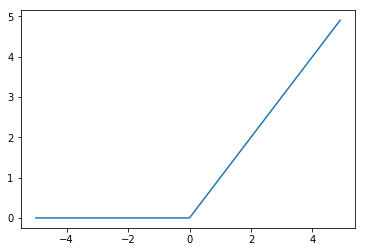

In [9]:
reluX = np.arange(-5,5,0.1)
relu = lambda x: np.where(x >= 0,x,0)
y = relu(reluX)
plt.plot(reluX,y)
plt.show()

In [10]:
class ReLU(Activation):
    
    def __init__(self):
        super().__init__()
        self.data = None
        
    def function(self,z):
        self.data = z
        self.x = np.where(z >= 0.,z,0.).astype(np.float64)
        return self.x
    
    def derivative(self,z):
        self.dx = np.where(self.data >= 0., 1. ,0.).astype(np.float64)
        return np.multiply(z,self.dx)

You can find more activation functions here: https://en.wikipedia.org/wiki/Activation_function 

Let's now proceed the optimizations we described earlier.

In [11]:
class Optimizer(object):
    
    def __init__(self,learning_rate = 0.01):
        self.learning_rate = learning_rate
        pass
    
    def optimize(self):
        pass

##### SGD 

$\theta = \theta - \nabla_\theta J(\theta)$ 

In [12]:
class SGD(Optimizer):
    def __init__(self,learning_rate = 0.1):
        super().__init__(learning_rate)
        
    def optimize(self,dW,db,decay):
        if decay:
            self.learning_rate /= 2
            
        return dW * self.learning_rate,db * self.learning_rate

##### Momentum 

$v_t = \gamma v_{t-1} + \alpha \nabla_\theta J(\theta)$

In [13]:
class Momentum(Optimizer):
    
    def __init__(self,Weight_size,bias_size,momentum_ratio = 0.9,learning_rate = 0.01):
        super().__init__(learning_rate)
        self.weight_updates = np.zeros(Weight_size)
        self.bias_updates = np.zeros(bias_size)
        self.ratio = momentum_ratio
        
    
    def optimize(self,dW,db,decay):
        if decay:
            self.learning_rate /= 2
        self.weight_updates = (self.ratio * self.weight_updates) + (self.learning_rate * dW)
        self.bias_updates = (self.ratio * self.bias_updates) + (self.learning_rate * db)
        return self.weight_updates,self.bias_updates
        

##### Adagrad

$\theta_{t+1} = \theta_t  - \dfrac{\alpha}{\sqrt{G_t + \varepsilon}} * g_t$

In [14]:
class Adagrad(Optimizer):
    def __init__(self,Weight_size,bias_size,learning_rate = 1,epsilon = 1e-8):
        super().__init__(learning_rate)
        self.weight_updates = np.zeros(Weight_size)
        self.bias_updates = np.zeros(bias_size)
        self.epsilon = epsilon
        
    
    def optimize(self,dW,db,decay):
        if decay:
            self.learning_rate /= 2
            
        self.weight_updates += dW ** 2
        self.bias_updates += db ** 2
        new_weight = (self.learning_rate / np.sqrt(self.weight_updates + self.epsilon)) * dW
        new_bias = (self.learning_rate / np.sqrt(self.bias_updates + self.epsilon)) * db
        return new_weight,new_bias

##### Adam

$m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t$

$v_t = \beta_2 v_{t-1} + (1 - \beta_2)g{_t}^2$ 

--

$\hat{m_t} = \dfrac{m_t}{1 - \beta_{1}^t}$

$\hat{v_t} = \dfrac{v_t}{1 - \beta_{2}^t}$

--

$\theta_t = \theta_t - \dfrac{\alpha}{\sqrt{\hat{v_t}} + \varepsilon} \hat{m_t}$

In [15]:
class Adam(Optimizer):
    def __init__(self,Weight_size,bias_size,learning_rate = 0.1,beta1 = 0.9,beta2= 0.999,epsilon = 1e-8):
        super().__init__(learning_rate)
        self.weight_momentum = np.zeros(Weight_size)
        self.weight_velocity = np.zeros(Weight_size)
        self.bias_momentum = np.zeros(bias_size)
        self.bias_velocity = np.zeros(bias_size)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
    
    def optimize(self,dW,db,decay):
        if decay:
            self.learning_rate /= 2
        
        self.weight_momentum = (self.beta1 * self.weight_momentum) + (1 - self.beta1) * dW
        self.weight_velocity = (self.beta2 * self.weight_velocity) + (1 - self.beta2) * (dW ** 2)
        
        self.bias_momentum = (self.beta1 * self.bias_momentum) + (1 - self.beta1) * db
        self.bias_velocity = (self.beta2 * self.bias_velocity) + (1 - self.beta2) * (db ** 2)
        
        mw_hat = self.weight_momentum / (1 - self.beta1)
        vw_hat = self.weight_velocity / (1 - self.beta2)
        
        mb_hat = self.bias_momentum / (1 - self.beta1)
        vb_hat = self.bias_velocity / (1 - self.beta2)
        
        new_weight = (self.learning_rate /(np.sqrt(vw_hat) + self.epsilon)) * mw_hat
        new_bias = (self.learning_rate /(np.sqrt(vb_hat) + self.epsilon)) * mb_hat
        return new_weight,new_bias

Okay with that we are done adding classes. That sure was long and maybe confusing, but that just goes to show you how complex building a robust neural network is. Let's now test it.

## Testing the Network.

First let's load all the images like last time.

In [16]:
import matplotlib.cm as cm
digits = pd.read_csv("digits.csv")
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the values of the pixels of the image are in numbers between 0 and 255, and since that scale may affect the performance of some of our algorithms, we'll rescale the pixels to values between 0 and 1, by dividing all pixels by 255. When displaying the image, we just have to multiply the pixels by 255, and they'll be back to normal.

In [17]:
images = digits.drop("label",axis = 1).values.astype(np.float64) / 255
labels = pd.get_dummies(digits["label"]).values.astype(np.float64) #One hot
del digits # Save memory!
labels

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

Let's instantiate the network first.

In [18]:
network = Network(images,labels,epochs = 20)

And now all the layers. Let's first recreate the network we built in the previous notebook on this notebook, but with more outputs since we are predicting more than two labels.

In [19]:

#1st. 
first = LinearLayer(Weights = (784,256),bias = 256,optimizer = Adam((784,256),256))
network.layers.append(first)

#2nd
second = ActivationLayer(activation = TanH())
network.layers.append(second)

#3rd 
third = LinearLayer(Weights = (256,100),bias = 100, optimizer = Adam((256,100),100))
network.layers.append(third)

#4th

fourth= ActivationLayer(activation = TanH())
network.layers.append(fourth)

fifth = LinearLayer(Weights = (100,10),bias = 10, optimizer = Adam((100,10),10))
network.layers.append(fifth)

sixth= ActivationLayer(activation = TanH())
network.layers.append(sixth)

output = Cross_Entropy()
network.layers.append(output)

All that's missing is training the network, and seeing how it does...

In [20]:
network.Train(noise = False)

End of epoch, train error :   0.14494047619   Test error :  0.149642857143
End of epoch, train error :   0.121220238095   Test error :  0.124047619048
End of epoch, train error :   0.111845238095   Test error :  0.115
End of epoch, train error :   0.108035714286   Test error :  0.11
End of epoch, train error :   0.104255952381   Test error :  0.107619047619
End of epoch, train error :   0.101488095238   Test error :  0.104642857143
End of epoch, train error :   0.0995238095238   Test error :  0.101666666667
End of epoch, train error :   0.096130952381   Test error :  0.100357142857
End of epoch, train error :   0.0937202380952   Test error :  0.0988095238095
End of epoch, train error :   0.0919047619048   Test error :  0.0983333333333
End of epoch, train error :   0.0899107142857   Test error :  0.0960714285714
End of epoch, train error :   0.0885714285714   Test error :  0.0953571428571
End of epoch, train error :   0.0873214285714   Test error :  0.0944047619048
End of epoch, train e

So our previous network would get a 90% accuracy on the test set if used on the full dataset. Let's try with a more complex network now.

In [21]:
New_Layers = []
#1st. 
first2 = LinearLayer(Weights = (784,392),bias = 392, optimizer = SGD())
New_Layers.append(first2)

#2nd
second2 = ActivationLayer(activation = ReLU())
New_Layers.append(second2)

#3rd 
third2 = LinearLayer(Weights = (392,196),bias = 196, optimizer = Adam((392,196),196))
New_Layers.append(third2)

#4th
fourth2 = ActivationLayer(activation = TanH(), dropout = 0.5)
New_Layers.append(fourth2)

#5th
fifth2 = LinearLayer(Weights = (196,98),bias = 98, optimizer = Adagrad((196,98),98))
New_Layers.append(fifth2)

#6th
sixth2 = ActivationLayer(activation = Sigmoid())
New_Layers.append(sixth2)

#7th
seventh2 = LinearLayer(Weights = (98,10),bias = 10, optimizer = Momentum((98,10),10)) 
New_Layers.append(seventh2)

output2 = Cross_Entropy()
New_Layers.append(output2)


In [22]:
network2 = Network(images,labels,epochs = 30, layers = New_Layers)
network2.Train(noise = True)

End of epoch, train error :   0.22869047619   Test error :  0.232142857143
End of epoch, train error :   0.168660714286   Test error :  0.170476190476
End of epoch, train error :   0.14244047619   Test error :  0.145119047619
End of epoch, train error :   0.127202380952   Test error :  0.130952380952
End of epoch, train error :   0.116369047619   Test error :  0.117976190476
End of epoch, train error :   0.109047619048   Test error :  0.1125
End of epoch, train error :   0.0991964285714   Test error :  0.104523809524
End of epoch, train error :   0.0954166666667   Test error :  0.0997619047619
End of epoch, train error :   0.0896130952381   Test error :  0.0947619047619
End of epoch, train error :   0.086755952381   Test error :  0.0913095238095
End of epoch, train error :   0.0846428571429   Test error :  0.0911904761905
End of epoch, train error :   0.0816964285714   Test error :  0.0870238095238
End of epoch, train error :   0.0791071428571   Test error :  0.0845238095238
End of epo

So this network arquitecture gets a better accuracy when testing than our preivous one. Experiment with various different architectures, and find out which ones work and which ones dont!

## Further reading

NN Optimization: http://cs231n.github.io/optimization-1/
NN Architecture: https://cs.stanford.edu/people/eroberts/courses/soco/projects/neural-networks/Architecture/index.html